<a href="https://colab.research.google.com/github/ndronen/econdata/blob/main/Corruption_and_GDP_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [3]:
DRIVE_PATH = "/content/gdrive"
NOTEBOOK_PATH = f"{DRIVE_PATH}/My Drive/Colab Notebooks"
drive.mount(DRIVE_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
CORRUPTION_URL = "https://raw.githubusercontent.com/ndronen/econdata/9d8ce906727aad587844dc78e0617a79a3a0c5b4/corruption-perceptions-index-2021-transparency-org.csv"

In [5]:
GDP_URL = "https://raw.githubusercontent.com/ndronen/econdata/fa2261bdbaed8857acad2cdfea5a5f45b3fa3d7c/gdp-per-capita-of-countries-in-current-usd-world-bank.csv"

In [6]:
corruption_df = pd.read_csv(CORRUPTION_URL)
gdp_df = pd.read_csv(GDP_URL)

In [7]:
corruption_df.columns

Index(['Country / Territory', 'ISO3', 'Region', 'CPI score 2021', 'Rank',
       'Standard error', 'Number of sources', 'Lower CI', 'Upper CI',
       'African Development Bank CPIA',
       'Bertelsmann Foundation Sustainable Governance Index',
       'Bertelsmann Foundation Transformation Index',
       'Economist Intelligence Unit Country Ratings',
       'Freedom House Nations in Transit',
       'Global Insights Country Risk Ratings',
       'IMD World Competitiveness Yearbook', 'PERC Asia Risk Guide',
       'PRS International Country Risk Guide',
       'Varieties of Democracy Project', 'World Bank CPIA',
       'World Economic Forum EOS', 'World Justice Project Rule of Law Index'],
      dtype='object')

In [8]:
gdp_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       'Unnamed: 66'],
      dtype='object')

In [9]:
GDP_COUNTRY_CODE = "Country Code"
GDP_COUNTRY_NAME = "Country Name"
CORRUPTION_COUNTRY_CODE = "ISO3"
CORRUPTION_COUNTRY_NAME = "Country / Territory"
CORRUPTION_INDEX = "CPI score 2021"


def get_gdp_code_to_name(gdp_df):
    code = gdp_df[GDP_COUNTRY_CODE]
    name = gdp_df[GDP_COUNTRY_NAME]
    gdp_code_to_name = dict(zip(code, name))
    return gdp_code_to_name


def get_corruption_code_to_name(corruption_df):
    code = corruption_df[CORRUPTION_COUNTRY_CODE]
    name = corruption_df[CORRUPTION_COUNTRY_NAME]
    corruption_code_to_name = dict(zip(code, name))
    return corruption_code_to_name


def get_common_codes(gdp_codes, corruption_codes):
    common_codes = set(gdp_codes).intersection(corruption_codes)
    return common_codes


def get_common_code_subset(common_codes, df, code_column_name):
    mask = df[code_column_name].apply(lambda code: code in common_codes)
    df = df[mask]
    df = df.sort_values(code_column_name)
    return df


def join_dataframes(gdp_df, corruption_df):
    gdp_df.reset_index(inplace=True)
    corruption_df.reset_index(inplace=True)
    joined_df = pd.concat((gdp_df, corruption_df), axis=1)
    return joined_df

In [10]:
gdp_code_to_name = get_gdp_code_to_name(gdp_df)
corruption_code_to_name = get_corruption_code_to_name(corruption_df)
common_codes = get_common_codes(gdp_code_to_name.keys(), corruption_code_to_name.keys())
clean_gdp_df = get_common_code_subset(common_codes, gdp_df, GDP_COUNTRY_CODE)
clean_corruption_df = get_common_code_subset(common_codes, corruption_df, CORRUPTION_COUNTRY_CODE)
joined_df = join_dataframes(clean_gdp_df, clean_corruption_df)

In [11]:
def only_countries_with_gdp_in_year(df, year):
    has_gdp = ~df[year].isnull()
    return df[has_gdp]


def plot_cpi_against_gdp_for_year(df, year, xmax=None):
    df_year = only_countries_with_gdp_in_year(joined_df, year)
    fig, ax = plt.subplots(1, figsize=(12, 4))
    ax.scatter(df_year[year], df_year[CORRUPTION_INDEX])
    ax.set_xlabel(f"GDP in {year}")
    ax.set_ylabel("Corruption (CPI)")
    if xmax is not None:
        ax.set_xlim((0, xmax))

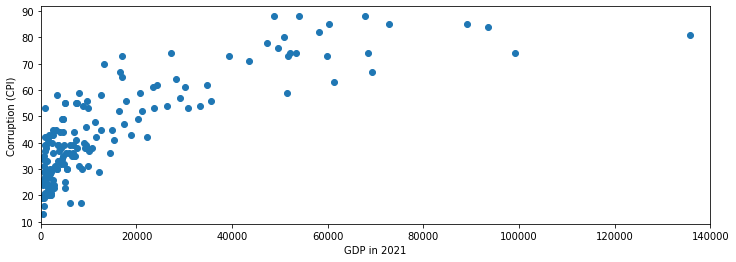

In [12]:
plot_cpi_against_gdp_for_year(joined_df, "2021", xmax=140000)

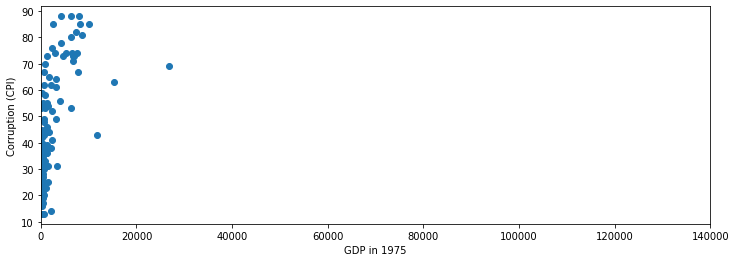

In [13]:
plot_cpi_against_gdp_for_year(joined_df, "1975", xmax=140000)

In [14]:
def plot_cpi_against_change_in_gdp_per_capita(df, start_year, end_year, xmax=None):
    def get_codes(year):
        return only_countries_with_gdp_in_year(df, year)[GDP_COUNTRY_CODE]

    start_year_codes = get_codes(start_year)
    end_year_codes = get_codes(end_year)
    common_codes = get_common_codes(start_year_codes, end_year_codes)

    mask = df[GDP_COUNTRY_CODE].apply(lambda code: code in common_codes)
    df_start_end = df[mask]
    change_in_gdp_per_capita = df_start_end[end_year] - df_start_end[start_year]
    label = f"{start_year}-{end_year}"
    df_start_end[label] = change_in_gdp_per_capita

    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.scatter(change_in_gdp_per_capita, df_start_end[CORRUPTION_INDEX])
    ax.set_xlabel(f"Change in GDP per capita from {start_year} to {end_year}")
    ax.set_ylabel("Corruption (CPI) in 2021")
    if xmax is not None:
        ax.set_xlim((0, xmax))
    fig.savefig(
        f"{NOTEBOOK_PATH}/change-in-gdp-per-capita-{start_year}-to-{end_year}.png",
        dpi=300
    )
    return df_start_end, label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


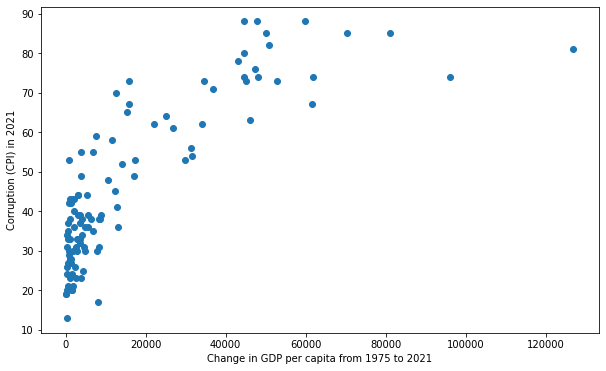

In [15]:
df_start_end, label = plot_cpi_against_change_in_gdp_per_capita(joined_df, "1975", "2021")

In [16]:
columns = [GDP_COUNTRY_NAME, GDP_COUNTRY_CODE, CORRUPTION_INDEX, label]
df_start_end[columns].sort_values(label)

,Country Name,Country Code,CPI score 2021,1975-2021
9,Burundi,BDI,19,123.042258
31,"Congo, Dem. Rep.",COD,19,137.130869
101,Madagascar,MDG,26,212.756634
144,Somalia,SOM,13,262.583652
142,Sierra Leone,SLE,34,292.257228
24,Central African Republic,CAF,24,318.129763
116,Niger,NER,31,392.668008
138,Sudan,SDN,20,416.330933
155,Chad,TCD,20,484.954579
113,Malawi,MWI,35,528.776942
